Buy/Sell Recommendation System using K-Means Clustering

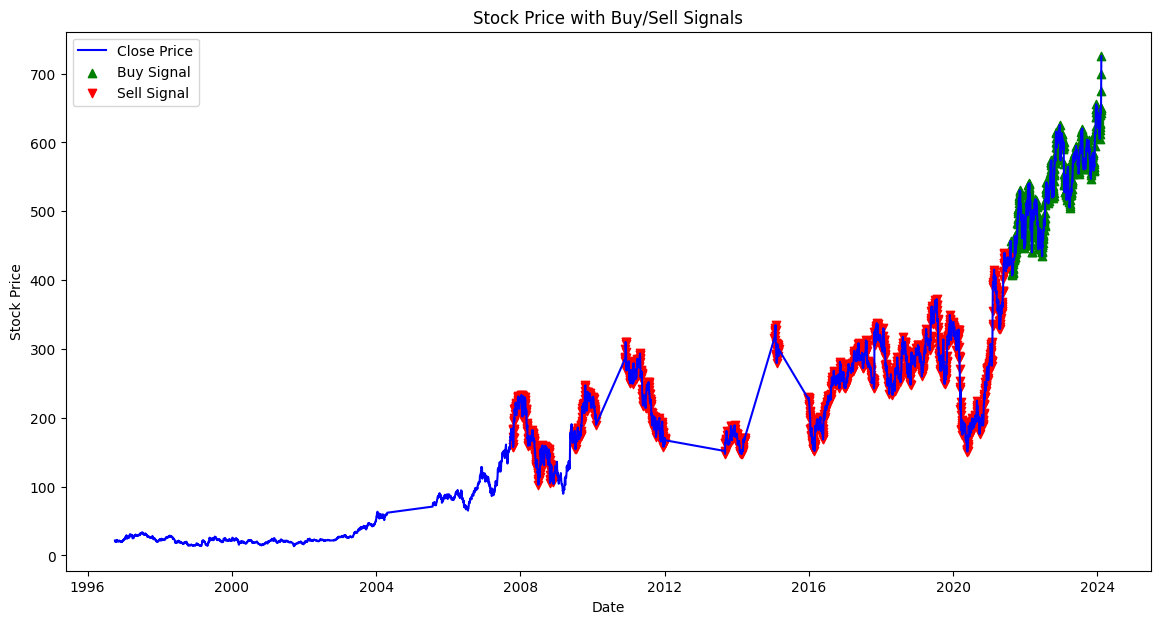

In [1]:
# Import necessary libraries
import modin.pandas as pd
import numpy as np
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Load stock data from CSV
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('drive/My Drive/Colab Notebooks/Stock Price Prediction RNN/SBIN.csv')
stock_data['Date'] = pd.to_datetime(stock_data['Date'], format='%d-%m-%Y')
stock_data.set_index('Date', inplace=True)

# ## Preprocess the Data to Add Technical Indicators
def calculate_technical_indicators(stock_data):
    # Forward fill any NA values before calculating percentage change
    stock_data['Returns'] = stock_data['Close'].ffill().pct_change()
    
    # Calculate moving averages
    stock_data['MA_50'] = stock_data['Close'].rolling(window=50).mean()
    stock_data['MA_200'] = stock_data['Close'].rolling(window=200).mean()
    
    # Calculate volatility (standard deviation of returns)
    stock_data['Volatility'] = stock_data['Returns'].rolling(window=50).std()
    
    # Drop NaN values resulting from rolling windows
    stock_data.dropna(inplace=True)
    
    return stock_data

# Apply the preprocessing
stock_data = calculate_technical_indicators(stock_data)

# ## Feature Set for Clustering
features = stock_data[['Returns', 'MA_50', 'MA_200', 'Volatility']]

# ## Apply K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
stock_data['Cluster'] = kmeans.fit_predict(features)

# ## Define 'Buy', 'Sell', 'Hold' Clusters
cluster_map = {0: 'Hold', 1: 'Buy', 2: 'Sell'}
stock_data['Signal'] = stock_data['Cluster'].map(cluster_map)

# ## Plot the Buy/Sell Signals on Stock Price
plt.figure(figsize=(14, 7))
plt.plot(stock_data['Close'], label='Close Price', color='blue')
buy_signals = stock_data[stock_data['Signal'] == 'Buy']
sell_signals = stock_data[stock_data['Signal'] == 'Sell']
plt.scatter(buy_signals.index, buy_signals['Close'], label='Buy Signal', marker='^', color='green')
plt.scatter(sell_signals.index, sell_signals['Close'], label='Sell Signal', marker='v', color='red')
plt.title('Stock Price with Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

Silhouette Score: 0.7111919059346077


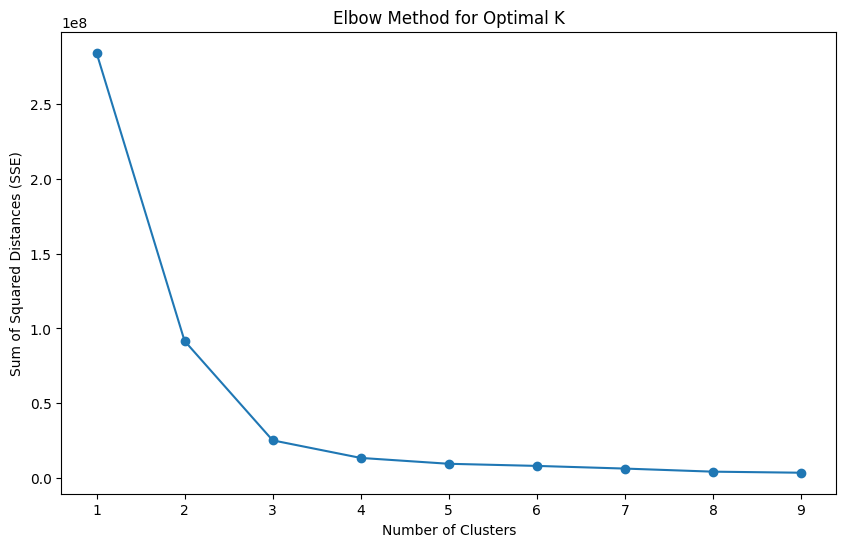

In [2]:
# ## Calculate Silhouette Score
silhouette_avg = silhouette_score(features, stock_data['Cluster'])
print(f'Silhouette Score: {silhouette_avg}')

# ## Elbow Method to Find Optimal Number of Clusters
sse = []
k_range = range(1, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances (SSE)')
plt.show()


In [3]:
# ## Backtest the Strategy
initial_balance = 100000  # Assume you start with $100,000
balance = initial_balance
positions = 0
stock_price_at_last_signal = 0  # To store the price of stock at the last signal

for i in range(1, len(stock_data)):
    signal = stock_data['Signal'].iloc[i]
    price = stock_data['Close'].iloc[i]

    if signal == 'Buy' and positions == 0:
        # Buy as much stock as possible
        positions = balance / price
        stock_price_at_last_signal = price
        print(f'Bought at {price}, positions = {positions}')
        balance = 0  # All money invested

    elif signal == 'Sell' and positions > 0:
        # Sell all positions
        balance = positions * price
        positions = 0
        profit = (price - stock_price_at_last_signal) * (balance / price)
        print(f'Sold at {price}, balance = {balance}, profit = {profit}')

# ## Final Portfolio Value (Including Any Remaining Stock)
final_portfolio_value = balance + positions * stock_data['Close'].iloc[-1]
print(f'Final Portfolio Value: {final_portfolio_value}')
print(f'Net Profit/Loss: {final_portfolio_value - initial_balance}')

Bought at 429.950012, positions = 232.5851778322546
Final Portfolio Value: 168682.40022284264
Net Profit/Loss: 68682.40022284264
